#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

### Импортируем все необходимые библиотеки и функции

In [1]:
!pip install -q lightgbm 

In [2]:
import pandas as pd
import numpy as np
import time


import seaborn as sb 
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose


import lightgbm as lgb

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer, make_column_selector, make_column_transformer
from catboost import CatBoostRegressor, Pool
from sklearn.dummy import DummyRegressor


import warnings
warnings.filterwarnings('ignore')

import os

In [3]:
RANDOM_STATE = 12345

### Загрузим датасет 

In [4]:
pth1 = 'taxi.csv'
pth2 = '/datasets/taxi.csv'

if os.path.exists(pth1):
    data = pd.read_csv(pth1)
elif os.path.exists(pth2):
    data = pd.read_csv(pth2)
else:
    print('Something is wrong') 

### Выведем общую информацию о датасете и его первые 5 строк, чтобы понять, какая информация в нем представлена и типы данных столбцов.

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [6]:
data.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


### Проверим на всякий случай, нет ли дубликатов.

In [7]:
data.duplicated().sum()

0

### В датасете 26496 строк и два столбца, пропусков нет, дубликатов нет. Столбец datetime надо перевести в формат datetime64 и сделать этот столбец индексами

In [8]:
data['datetime'] = pd.to_datetime(data['datetime'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


In [9]:
data = data.set_index('datetime')
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


### Отсортируем данные по дате (индексу) и проверим в хронологическом ли порядке расположены даты.

In [10]:
data.sort_index(inplace=True)

In [11]:
data.index.is_monotonic

True

### В соответствии с задачей проведем ресемплирование данных по одному часу

In [12]:
df = data.resample('1H').sum()
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


 **Итог:** На данном этапе загрузили данные, перевели столбец datetime в формат datetime64 и сделали из него индексы, отсортировали их в хронологическом порядке. Затем согласно поставленной задаче, спрогнозировать количество заказов такси на следующий час, провели ресемпелирование данных по одному часу. В итоге получили датасет с количеством строк - 4416, данные представлены за 6 месяцев (период с 1 марта 2018 года по 31 августа 2016 года).

### Построим график количества заказов такси в час за период с  1 марта 2018 года по 31 августа 2018 года

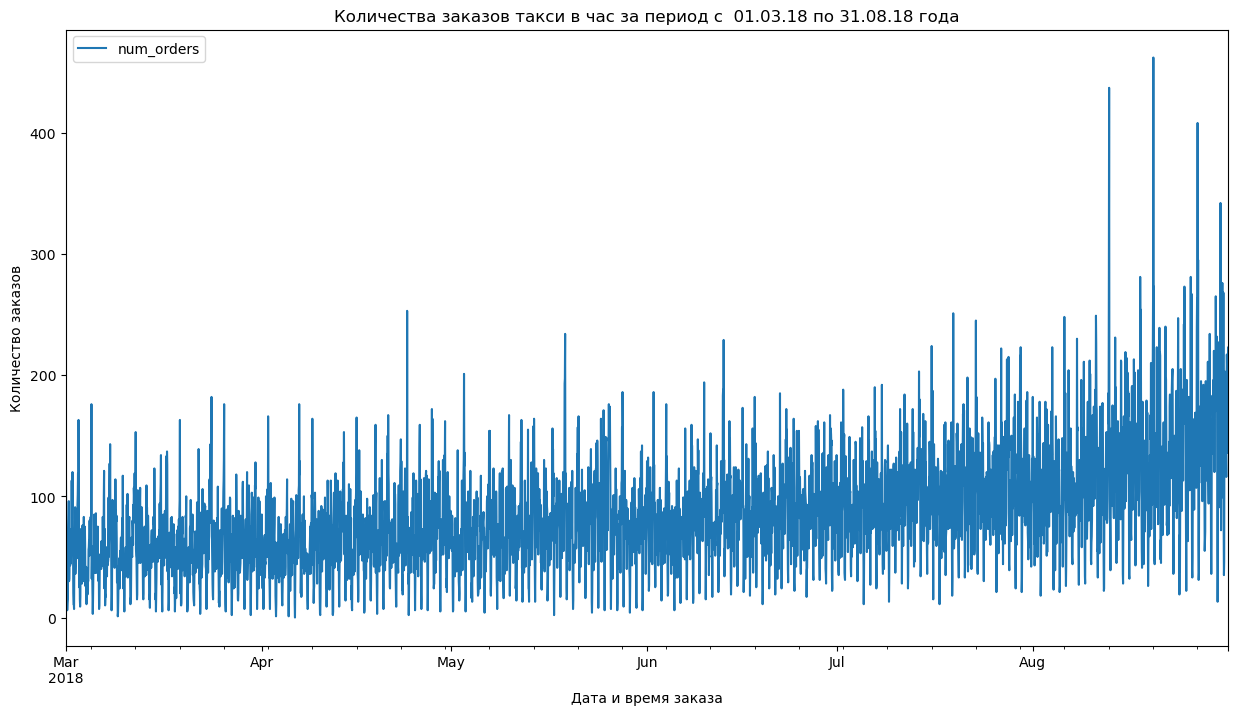

In [13]:
df.plot(figsize=(15,8))
plt.title('Количества заказов такси в час за период с  01.03.18 по 31.08.18 года')
plt.xlabel('Дата и время заказа')
plt.ylabel('Количество заказов')
plt.show()

Данных на графике много, он сложен для понимания, но уже сейчас виден тренд на увеличение количества заказов такси к августу месяцу.

### Построим график за более маленький период, например с 1 по 14 марта 2018 года (посмотрим период 2 недель)

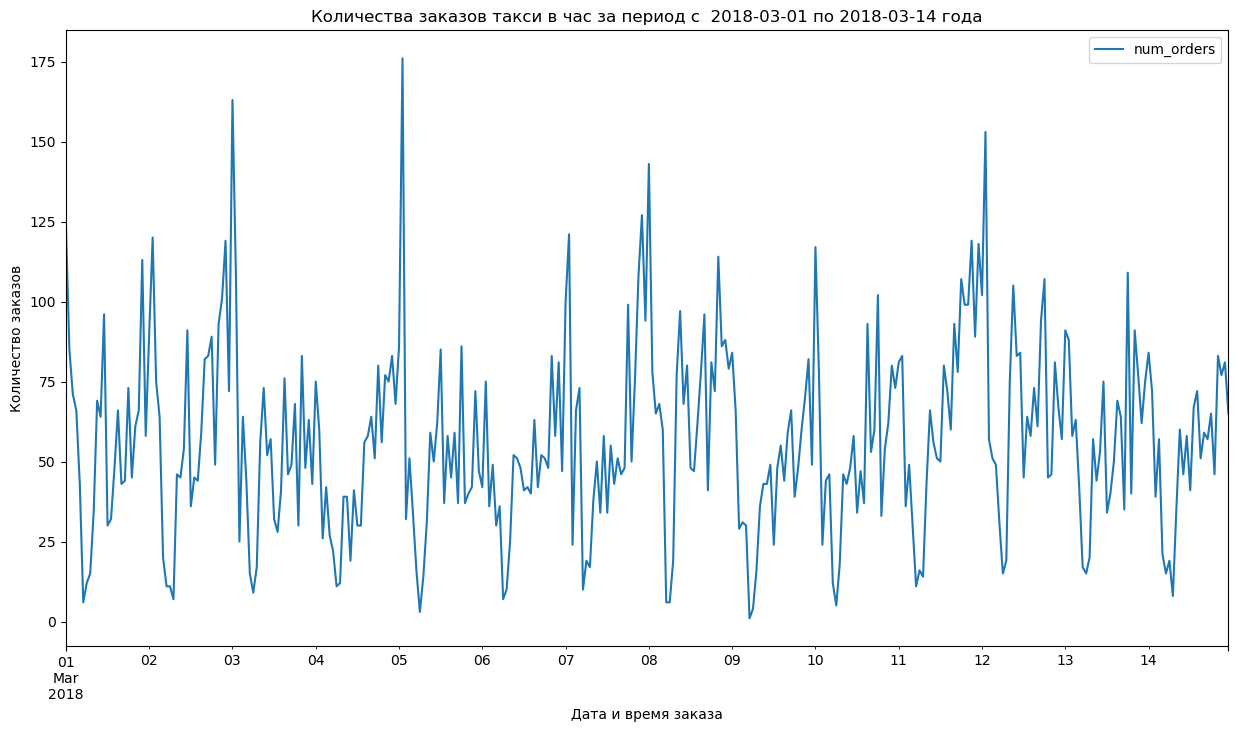

In [14]:
df['2018-03-01' : '2018-03-14'].plot(figsize=(15,8))
plt.title('Количества заказов такси в час за период с  2018-03-01 по 2018-03-14 года')
plt.xlabel('Дата и время заказа')
plt.ylabel('Количество заказов')
plt.show()

Из данного графика видно, что в течение дня наблюдаются коллебания количества заказов такси по часам, а изо дня в день наблюдается в целом похожая картина, т.е. можно говорить о некой "сезонности" период которой составляет 1 день.

### Для подтверждения наблюдений, разложим временной ряд на три составляющие тренд, сезонность, остаток с помощью функции seasonal_decompose()

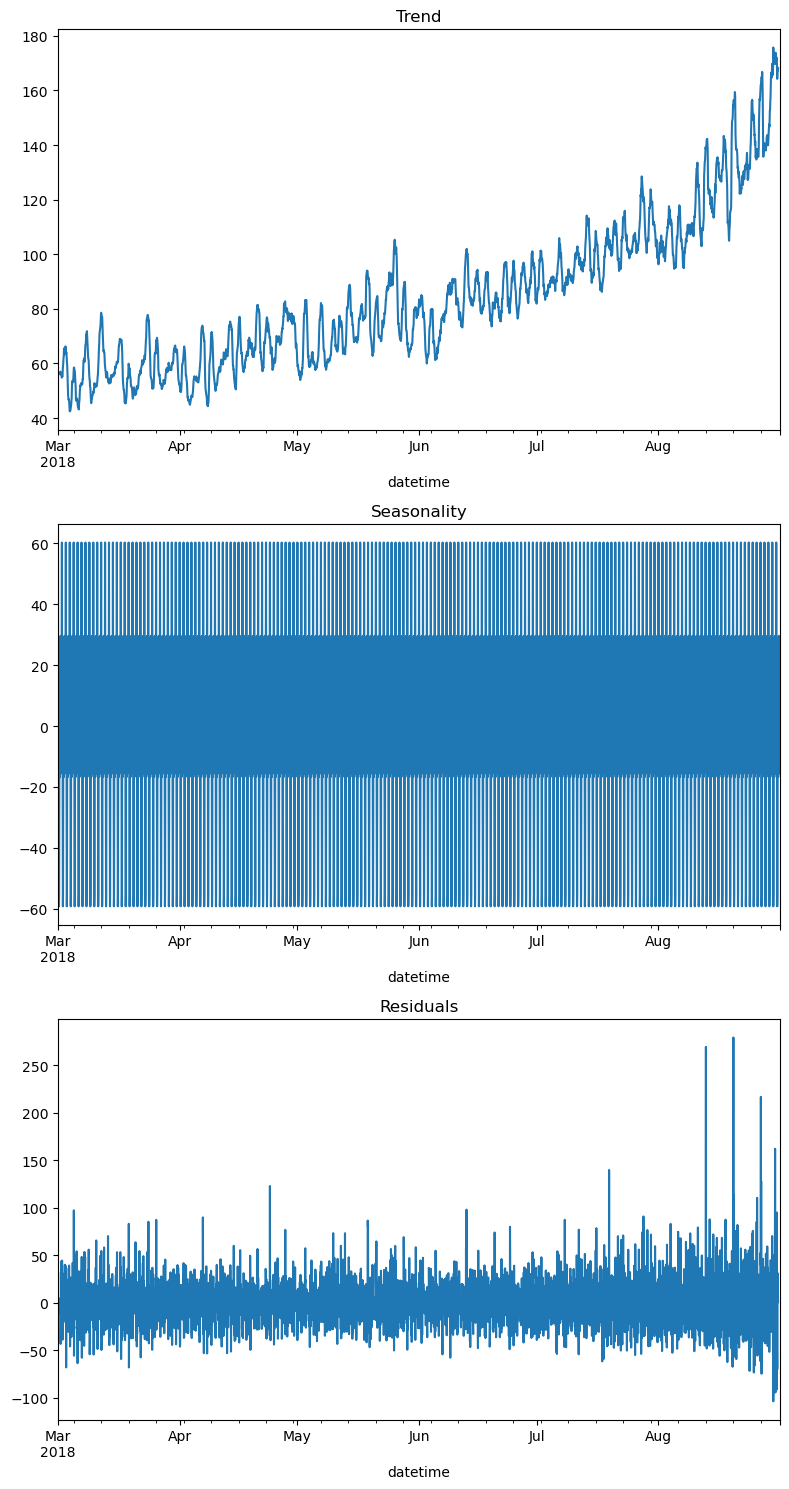

In [15]:
decomposed = seasonal_decompose(df)
plt.figure(figsize=(8,15))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

График тренда подтверждает наличие явного тренда на увеличение количества заказов такси в целом с марта по август. График сезонности и остатков пока не понятен, надо взять более короткий промежуток времени. Поосмотрим нрафик за период с 1 по 15 августа.

### Строим график сезонности за период с 1 по 15 августа 2018 года.

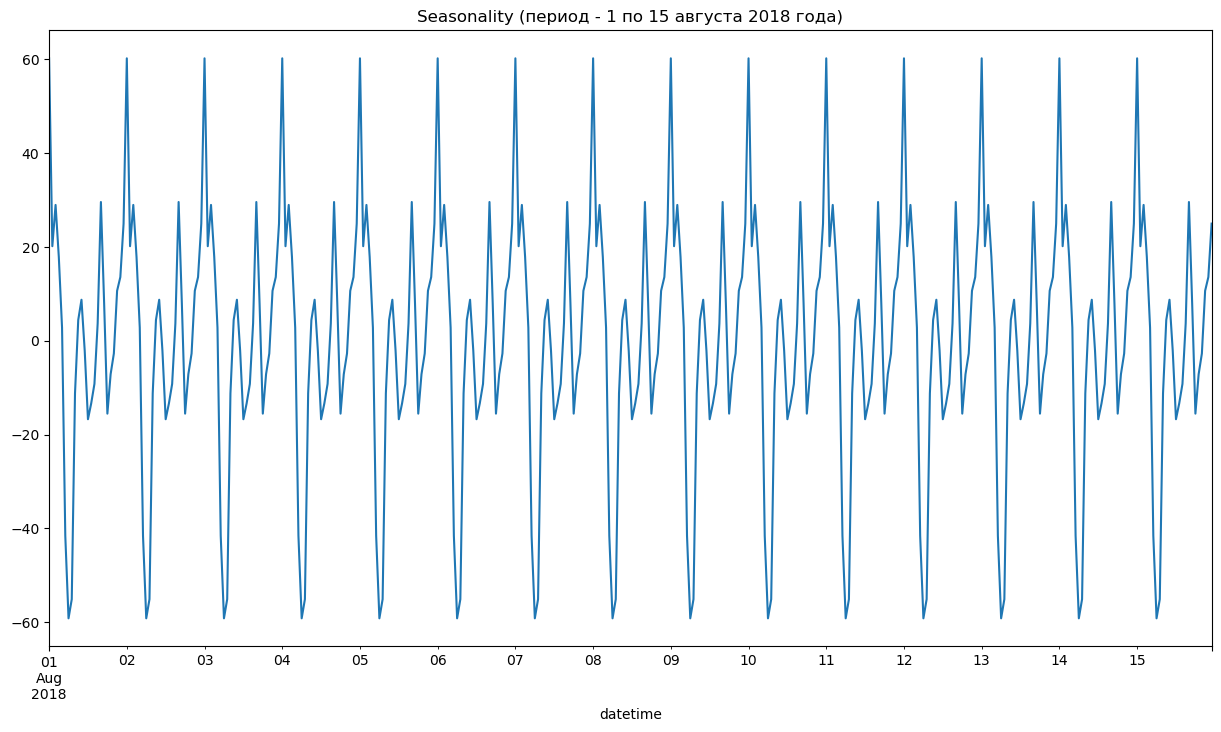

In [16]:
decomposed.seasonal['2018-08-01' : '2018-08-15'].plot(figsize=(15,8))
plt.title('Seasonality (период - 1 по 15 августа 2018 года)')
plt.show()

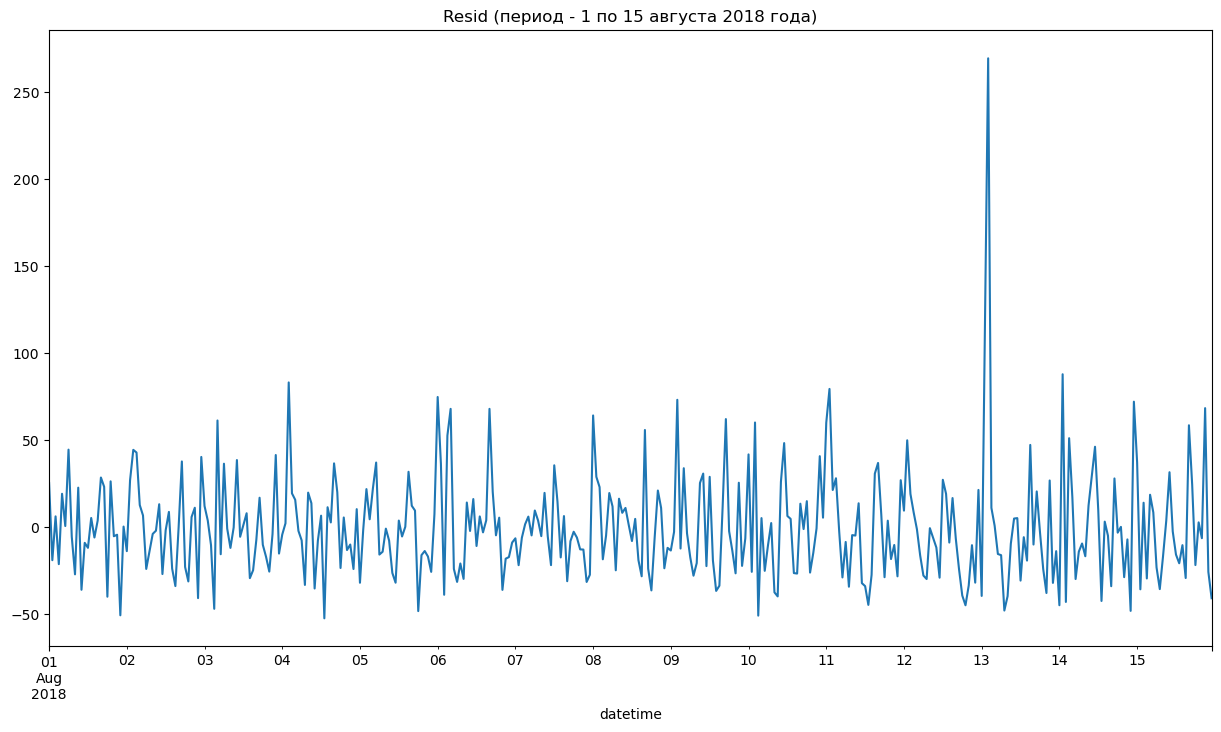

In [17]:
decomposed.resid['2018-08-01' : '2018-08-15'].plot(figsize=(15,8))
plt.title('Resid (период - 1 по 15 августа 2018 года)')
plt.show()

Данный график показывает, что есть циклично повторяющиеся закономерности во временном ряду. Длина цикла - 1 день. Пик количества заказов такси в аэропорт наблюдается в вечерние часы и в ночные часы, ранним утром количество заказов уменьшается. Также в данных есть шум.

### Посмотрим, есть ли недельная сезонность.  Для этого сделаем ресемплирование данных по одному дню

In [18]:
df_day = data.resample('1D').sum()
df_day.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 184 entries, 2018-03-01 to 2018-08-31
Freq: D
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  184 non-null    int64
dtypes: int64(1)
memory usage: 2.9 KB


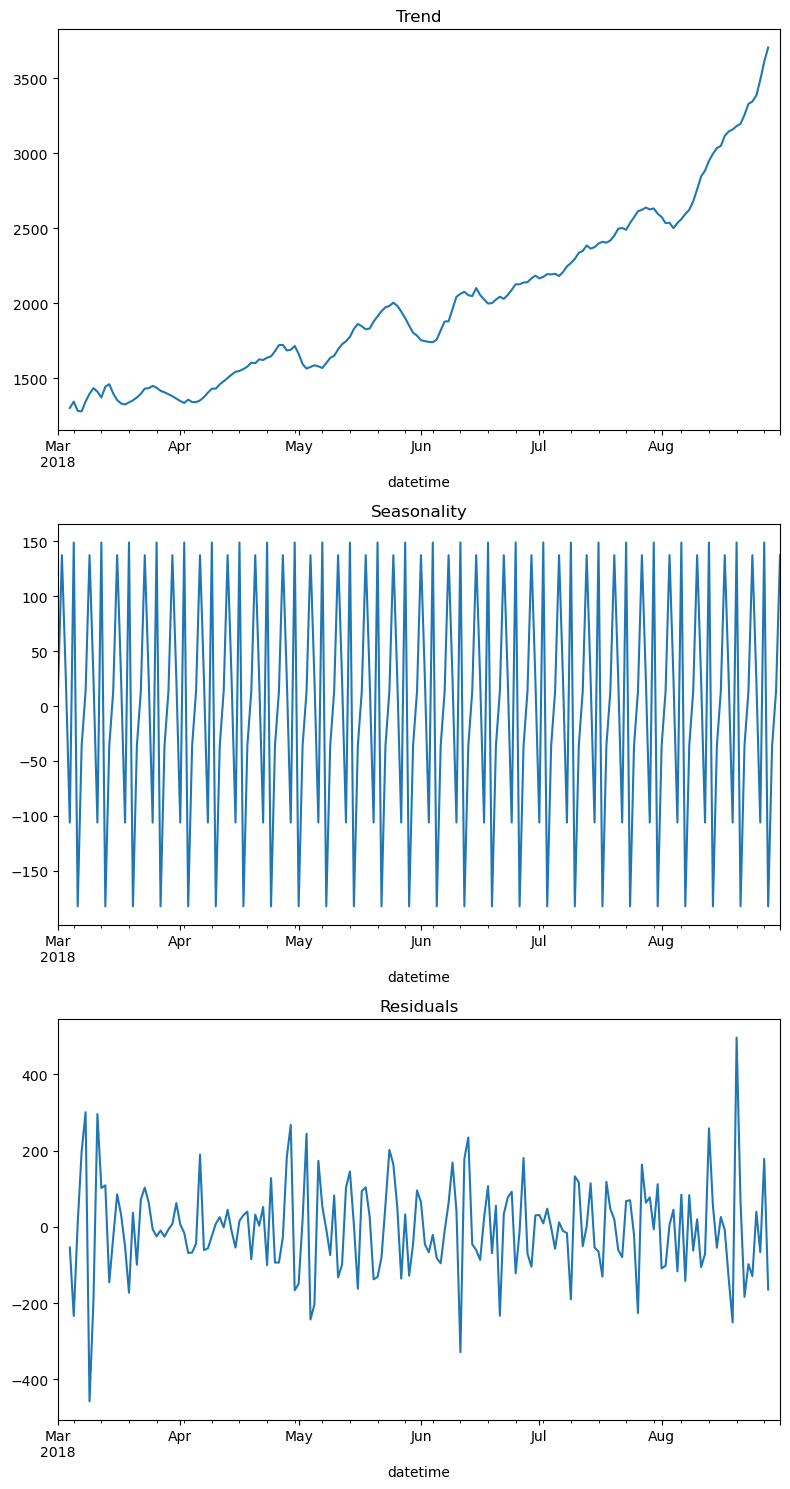

In [19]:
decomposed_day = seasonal_decompose(df_day)
plt.figure(figsize=(8,15))
plt.subplot(311)
decomposed_day.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed_day.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed_day.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

### Пострим график сезонности за две нелели августа, чтобы было более понятно 

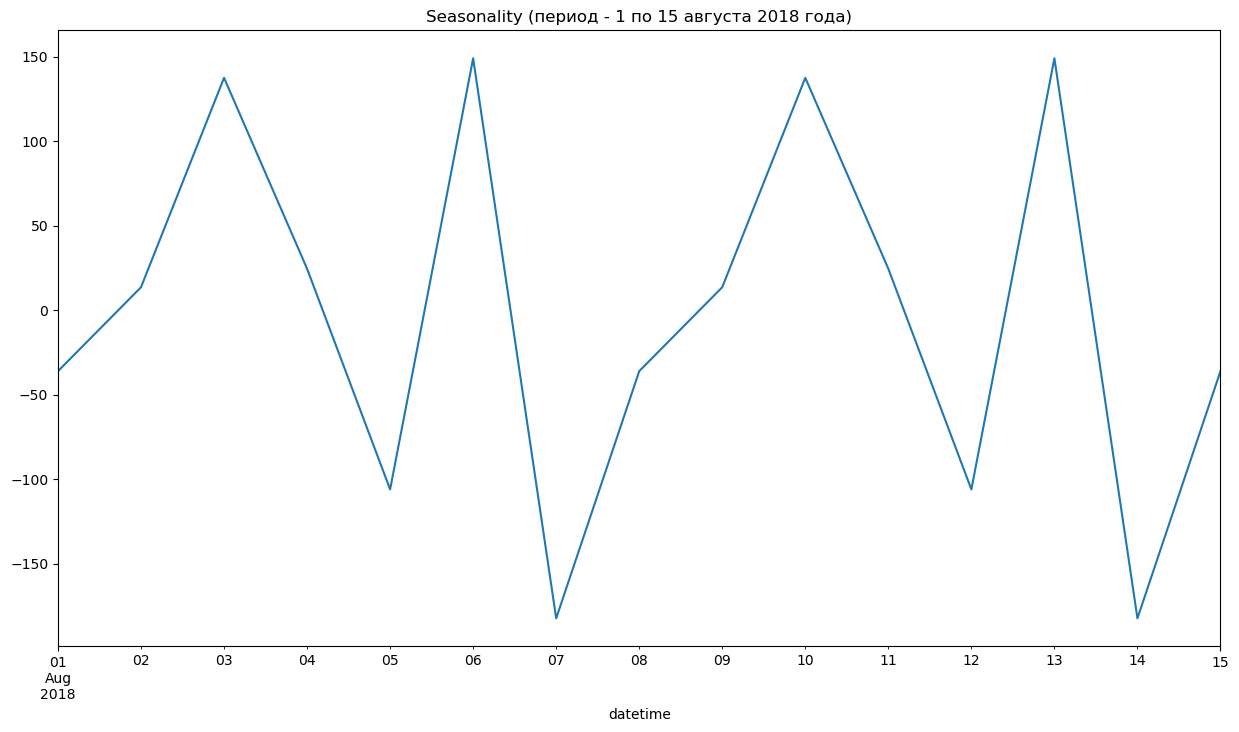

In [20]:
decomposed_day.seasonal['2018-08-01' : '2018-08-15'].plot(figsize=(15,8))
plt.title('Seasonality (период - 1 по 15 августа 2018 года)')
plt.show()

**Вывод** - прослеживается недельная сезонность, поэтому использование дня недели обосновано.

### Из полученных графиков видно, что ряд не стационарный, есть и сезонность и тренд. Чтобы убедиться построим графики  скользящего средннего и скользящего стандартного отклонения ( размером окна 24 - сутки)

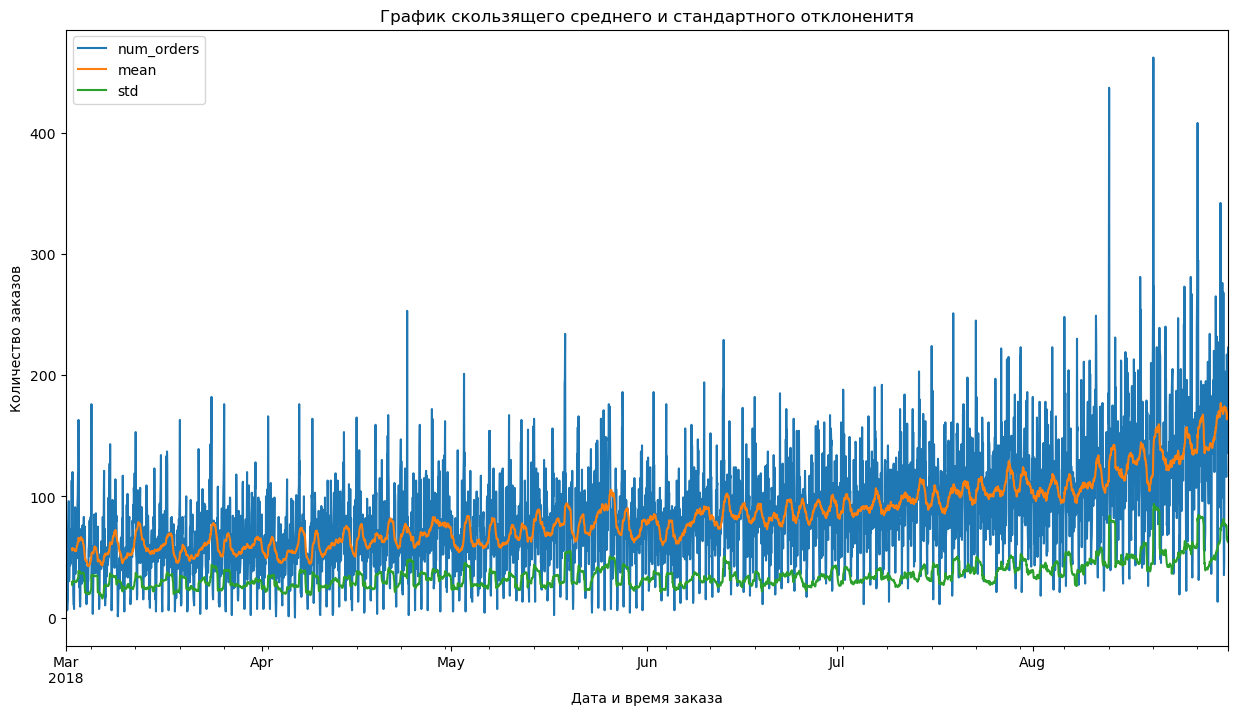

In [21]:
df['mean'] = df['num_orders'].rolling(24).mean()
df['std'] = df['num_orders'].rolling(24).std()
df.plot(figsize=(15,8))
plt.title('График скользящего среднего и стандартного отклоненитя')
plt.xlabel('Дата и время заказа')
plt.ylabel('Количество заказов')
plt.show()

Ряд нестационарный, т.к среднее и снтандартное отклонение меняются.

### Попробуем стабилизировать временной ряд.  Для этого найдем разности временного ряда и изобразим на графике скользящее средннее и скользящее стандартное отклонение ( размером окна 24  - сутки)

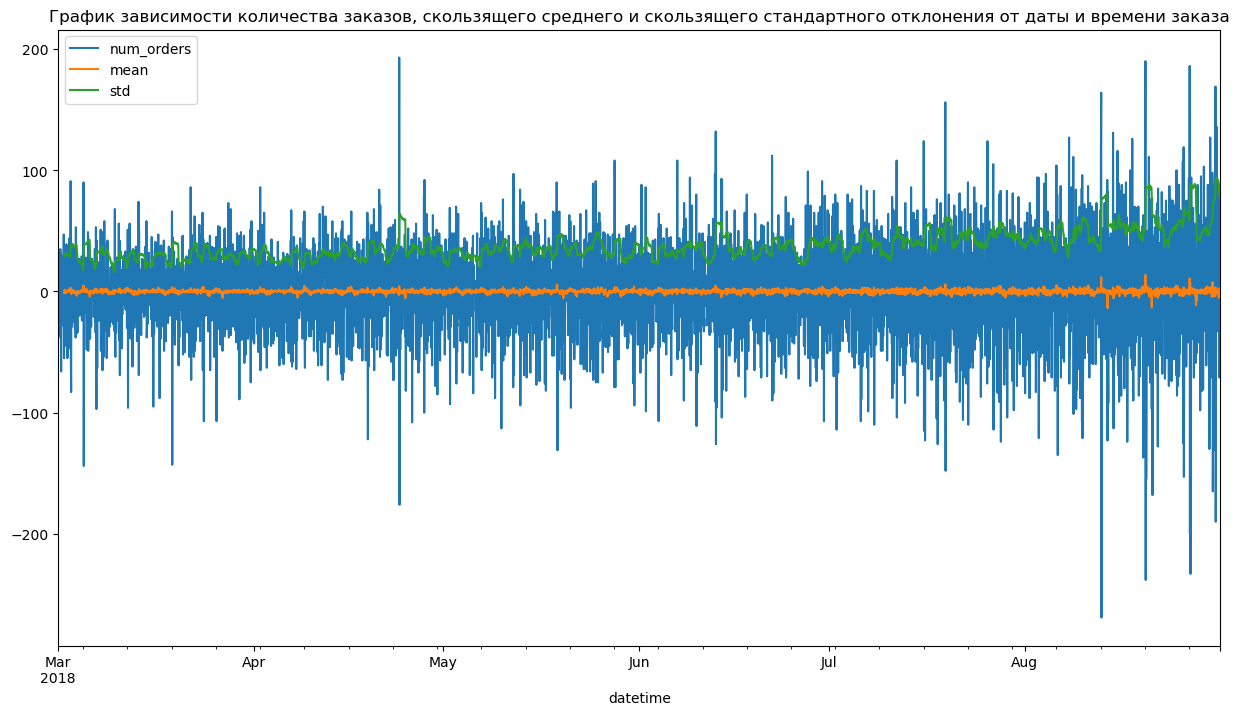

In [22]:
df_shift = df - df.shift()
df_shift['mean'] = df_shift['num_orders'].rolling(24).mean()
df_shift['std'] = df_shift['num_orders'].rolling(24).std()
df_shift.plot(figsize=(15,8))
plt.title('График зависимости количества заказов, скользящего среднего и скользящего стандартного отклонения от даты и времени заказа')
plt.show()


У смещенного временного ряда также прослеживается тренд (стандартное отклонение растет от марта к августу), но ряд стал более стабильным (среднее значение более постоянное). Однако для обучения модели будем использовать временной ряд без смещения, сгенерировав дополнительные признаки.

**Итог:** При аналимзе временного ряда было выявлено следующее:
        - временной ряд нестационарный (скользящее среднне и стандартное отклонение меняются);
        - есть выражденный тренд - увеличение количества заказов от марта к августу;
        - прослеживается сезонность, период которой составляет - 1 день. Пик количества заказов такси в аэропорт наблюдается в вечерние часы и в ночные часы, ранним утром количество заказов падает;
        - прослеживаетмя и недельная сезонность.

## Обучение

### Удалим столбцы скользящее среднее  и стандартное отклонение, которые были добавлены ранее. Создадим дополнительные признаки. В качестве дополнительных признаков будем использовать следующие параментры:  день, день недели и час, отстающие значения, скользящее среднее (с учетом того, что текущее значение ряда в расчет скользящего среднего не попадает, чтобы не было забегания вперед).  Для их создания напишем функцию make_features(), которая на вход принимает следующие параметры - временной ряд, max_lag - максимальное смещение, rolling_mean_size - размер окна. 

In [23]:
df = df.drop(['mean', 'std'], axis=1)
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [24]:
def make_features(data, max_lag, rolling_mean_size):
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    

#### Проверим работу функции make_features

In [25]:
data_1 = df.copy()
make_features(data_1, 2, 3)
display(data_1.head())
data_1.head()

,num_orders,day,dayofweek,hour,lag_1,lag_2,rolling_mean
datetime,,,,,,,
2018-03-01 00:00:00,124,1,3,0,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,3,1,124.0,NaN,NaN
2018-03-01 02:00:00,71,1,3,2,85.0,124.0,NaN
2018-03-01 03:00:00,66,1,3,3,71.0,85.0,93.333333
2018-03-01 04:00:00,43,1,3,4,66.0,71.0,74.000000


,num_orders,day,dayofweek,hour,lag_1,lag_2,rolling_mean
datetime,,,,,,,
2018-03-01 00:00:00,124,1,3,0,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,3,1,124.0,NaN,NaN
2018-03-01 02:00:00,71,1,3,2,85.0,124.0,NaN
2018-03-01 03:00:00,66,1,3,3,71.0,85.0,93.333333
2018-03-01 04:00:00,43,1,3,4,66.0,71.0,74.000000


In [26]:
del data_1 # удаляем датасет, который создали для проверки

### Создадим дополнительные признаки и разобъем данные на тестовую и обучающую выборки.  Так как у нас есть недельная сезонность - возьмем лаг 168 и окно - 24 часа равное суткам.

In [27]:
make_features(data=df, max_lag=168, rolling_mean_size=24)
train, test = train_test_split(df, shuffle = False, test_size = 0.1)
train = train.dropna()
features_train = train.drop('num_orders', axis = 1)
target_train = train['num_orders']
features_test = test.drop('num_orders', axis = 1)
target_test = test['num_orders']

In [28]:
features_train.info()
target_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3806 entries, 2018-03-08 00:00:00 to 2018-08-13 13:00:00
Freq: H
Columns: 172 entries, day to rolling_mean
dtypes: float64(169), int64(3)
memory usage: 5.0 MB
<class 'pandas.core.series.Series'>
DatetimeIndex: 3806 entries, 2018-03-08 00:00:00 to 2018-08-13 13:00:00
Freq: H
Series name: num_orders
Non-Null Count  Dtype
--------------  -----
3806 non-null   int64
dtypes: int64(1)
memory usage: 59.5 KB


In [29]:
features_test.info()
target_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 442 entries, 2018-08-13 14:00:00 to 2018-08-31 23:00:00
Freq: H
Columns: 172 entries, day to rolling_mean
dtypes: float64(169), int64(3)
memory usage: 597.4 KB
<class 'pandas.core.series.Series'>
DatetimeIndex: 442 entries, 2018-08-13 14:00:00 to 2018-08-31 23:00:00
Freq: H
Series name: num_orders
Non-Null Count  Dtype
--------------  -----
442 non-null    int64
dtypes: int64(1)
memory usage: 6.9 KB


**Разбили данные правильно**

### Рассмотрим модель Ridger. C помощью GridSearchCV подберем лучшие гиперпараметры, учитывая, что кросвалидация должна проходить без 'забега в будущее', для этого используем TimeSeriesSplit(). Также проведем масштабирование данных, т.к. для линейных моделей это важно. Отслеживаем метрику RMSE, по условию задания она должна быть меньше 48.

In [30]:
%%time
columns = features_train.columns
column_transformer_rd = make_column_transformer((StandardScaler(),columns), remainder = 'passthrough')
model_rd = Ridge(random_state=RANDOM_STATE)
pipline_rd = make_pipeline(column_transformer_rd, model_rd)
pipline_rd
        
param_rd = {
    'ridge__alpha': range(1,10,1)
                    }

grid_rd = GridSearchCV(pipline_rd, param_rd, cv=TimeSeriesSplit(n_splits=3), 
                               scoring='neg_root_mean_squared_error')
grid_rd.fit(features_train, target_train)

        
ridge_best_rmse = round(abs(grid_rd.best_score_), 3)
ridge_best_model = grid_rd.best_estimator_
ridge_best_params = grid_rd.best_params_
            
print(f'RMSE лучшей модели Ridge на обучающей выборке: {ridge_best_rmse}')
print(f'Гиперпараметры лучшей модели: {ridge_best_params}')


RMSE лучшей модели Ridge на обучающей выборке: 23.028
Гиперпараметры лучшей модели: {'ridge__alpha': 9}
Wall time: 800 ms


### Рассмотрим модель RandomForestRegressor. Поступаем аналогично, но так как гиперпараметров больше, будем использовать RandomizedSearchCV. Также сделаем маштабирование данных, хотя для деревянных модлей это не так критично. 

In [31]:
%%time
column_transformer_rf = make_column_transformer((StandardScaler(),columns), remainder = 'passthrough')
model_rf = RandomForestRegressor(random_state=RANDOM_STATE)
pipline_rf = make_pipeline(column_transformer_rf, model_rf)
                
param_rf = {
    'randomforestregressor__n_estimators': range(10, 60, 10),
    'randomforestregressor__max_depth': range(1, 10),
    'randomforestregressor__min_samples_split': (2, 3, 4),
    'randomforestregressor__min_samples_leaf': (1, 2, 3, 4)
}



grid_rf = RandomizedSearchCV(pipline_rf, param_rf, cv=TimeSeriesSplit(n_splits=3), n_iter=10, 
                               scoring='neg_root_mean_squared_error', n_jobs=-1, random_state=RANDOM_STATE)
grid_rf.fit(features_train, target_train)


rf_best_rmse = round(abs(grid_rf.best_score_), 3)
rf_best_model = grid_rf.best_estimator_
rf_best_params = grid_rf.best_params_
           

print(f'RMSE лучшей модели RandomForestRegressor на обучающей выборке: {rf_best_rmse}')
print(f'Гиперпараметры лучшей модели: {rf_best_params}')

RMSE лучшей модели RandomForestRegressor на обучающей выборке: 23.847
Гиперпараметры лучшей модели: {'randomforestregressor__n_estimators': 50, 'randomforestregressor__min_samples_split': 2, 'randomforestregressor__min_samples_leaf': 4, 'randomforestregressor__max_depth': 8}
Wall time: 20.7 s


### Рассмотрим модель LGBMRegressor. Поступаем аналогично, но так как гиперпараметров больше, будем использовать RandomizedSearchCV.

In [32]:
%%time
model_lg = LGBMRegressor(random_state=RANDOM_STATE)
                
param_lg = {
    'n_estimators': range(10, 100, 10),
    'num_leaves': range(10, 100, 10),
    
}

grid_lg = RandomizedSearchCV(model_lg, param_lg, cv=TimeSeriesSplit(n_splits=3), n_iter=20,  
                               scoring='neg_root_mean_squared_error', n_jobs=-1, random_state=RANDOM_STATE)
grid_lg.fit(features_train, target_train)

        
lg_best_rmse = round(abs(grid_lg.best_score_), 3)
lg_best_model = grid_lg.best_estimator_
lg_best_params = grid_lg.best_params_

print(f'RMSE лучшей модели  LGBMRegressor на обучающей выборке: {lg_best_rmse}')
print(f'Гиперпараметры лучшей модели: {lg_best_params}')

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004852 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31509
[LightGBM] [Info] Number of data points in the train set: 3806, number of used features: 172
[LightGBM] [Info] Start training from score 79.352864
RMSE лучшей модели  LGBMRegressor на обучающей выборке: 23.536
Гиперпараметры лучшей модели: {'num_leaves': 20, 'n_estimators': 40}
Wall time: 20.2 s


### Рассмотрим модель CatBoostRegressore. Поступаем аналогично, но так как гиперпараметров больше, будем использовать RandomizedSearchCV.

In [33]:
%%time
model_cb = CatBoostRegressor(random_seed=RANDOM_STATE, silent=True)
                
param_cb = {
            'learning_rate':[0.1, 0.3],
            'iterations': [40, 50, 60, 80],
            'depth': range(1, 10, 1),
}

grid_cb = RandomizedSearchCV(model_cb, param_cb, cv=TimeSeriesSplit(n_splits=3), n_iter=10,  
                               scoring='neg_root_mean_squared_error', n_jobs=-1, random_state=RANDOM_STATE)
grid_cb.fit(features_train, target_train)

        
cb_best_rmse = round(abs(grid_cb.best_score_), 3)
cb_best_model = grid_cb.best_estimator_
cb_best_params = grid_cb.best_params_
            
print(f'RMSE лучшей модели  CatBoostRegressore на обучающей выборке: {cb_best_rmse}')
print(f'Гиперпараметры лучшей модели: {cb_best_params}')

RMSE лучшей модели  CatBoostRegressore на обучающей выборке: 23.493
Гиперпараметры лучшей модели: {'learning_rate': 0.1, 'iterations': 60, 'depth': 3}
Wall time: 35.1 s


### Для сравнения моделей сведем данные в таблицу. Будем сравнивать по величине метрики RMSE, полученной при обучении моделей на обучающей выборке.

In [34]:
index = ['Ridger',
         'RandomForestRegressor',
         'LightGBM',
         'CatBoostRegressor']
dt = {'RMSE':[ridge_best_rmse, rf_best_rmse, lg_best_rmse, cb_best_rmse]}
                                          

compare = pd.DataFrame(data=dt, index=index)
display(compare)

,RMSE
Ridger,23.028
RandomForestRegressor,23.847
LightGBM,23.536
CatBoostRegressor,23.493


**Вывод:** На данном этапе были обучены 4 модели 'Ridger', 'RandomForestRegressor', 'LightGBM', 'CatBoostRegressor' для которых подбирали размер смещения, окна и гиперпараметры. Все модели показали приблизительно одинаковое значение RMSE, которое соответсвует поставленной задачи. Значение RMSE меньше 48. Самый хорошее значение RMSE у модели Ridger - 	23.028, также она достаточно быстро обучается, выбираем ее для дальнейшего тестирования.

## Тестирование

### Протестируем  модель Ridger, показавшую самый хороший результат,  на тестовой выборке.

In [35]:
%%time
start_time = time.time()
predictions_ridge_test = ridge_best_model.predict(features_test)
end_time = time.time()
pred_time = end_time - start_time
print('RMSE', mean_squared_error(target_test, predictions_ridge_test, squared=False).round(3))
print(pred_time)

RMSE 34.471
0.0060045719146728516
Wall time: 7 ms


**Вывод** - получили значение RMSE 34.471 на тестовой выборке, что соответсвует условию задачи.

### Проверим на адекватность и с помощью предсказывания следующего значения предыдущим

In [36]:
pred_previous = target_test.shift()
pred_previous.iloc[0] = target_train.iloc[-1]
print('RMSE', mean_squared_error(target_test, pred_previous, squared=False).round(2))

RMSE 58.86


**Вывод:** Наша модель показала лучший результат в сравнении с вариантом предсказывания значения предыдущим.

### Построим график реальных значений и график предсказаний

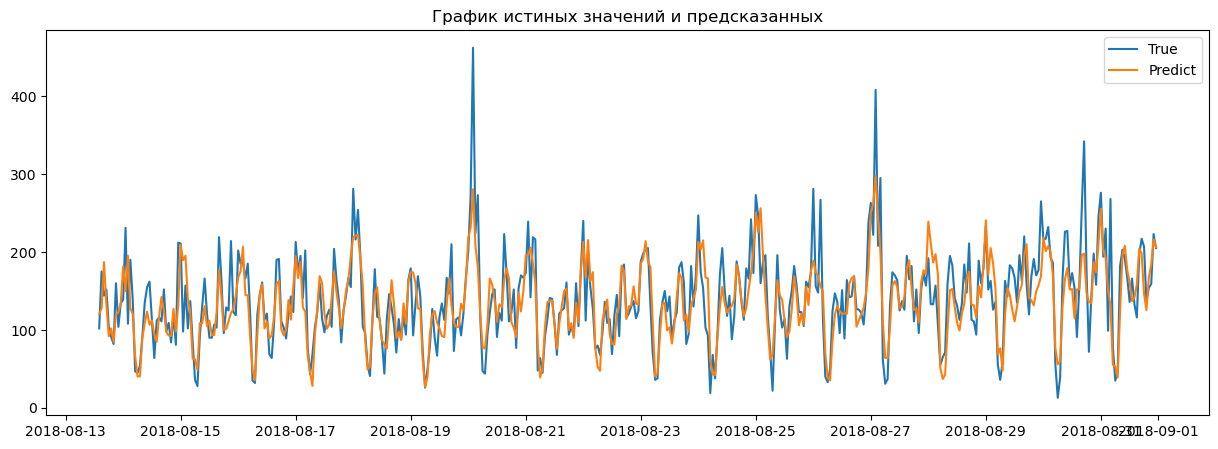

In [37]:
plt.figure(figsize=(15, 5))

plt.plot(target_test, label='True')
plt.plot(target_test.index, predictions_ridge_test, label='Predict')

plt.title('График истиных значений и предсказанных')
plt.legend()
plt.show()


**Вывод** Из графика видим, что модель достаточно хорошоо предсказывает общий тренд и сезонность, но плохо предсказывает выбивающиеся значения (шум).

**Итоговый вывод** В процессе выполнения задачи было сделано следующее:

1. Загрузили данные, перевели столбец datetime в формат datetime64 и сделали из него индексы, отсортировали их в хронологическом порядке. Затем согласно поставленной задаче, спрогнозировать количество заказов такси на следующий час, провели ресемпелирование данных по одному часу. В итоге получили датасет с количеством строк - 4416, данные представлены за 6 месяцев (период с 1 марта 2018 года по 31 августа 2016 года).

2. Провели анализ данных, который показал, что:
 - временной ряд нестационарный (скользящее среднне и стандартное отклонение меняются); 
 - есть выражденный тренд - увеличение количества заказов от марта к августу; 
 - прослеживается сезонность, период которой составляет - 1 день. Пик количества заказов такси в аэропорт наблюдается в вечерние часы и в ночные часы, ранним утром количество заказов падает;
 - прослеживается также недельная сезонность.
 
 
3.  Обучили 4 модели 'Ridger', 'RandomForestRegressor', 'LightGBM', 'CatBoostRegressor' для которых подбирали размер смещения, окна и гиперпараметры. Все модели показали приблизительно одинаковое значение RMSE, которое соответсвует поставленной задачи (значение RMSE меньше 48). Самый хорошее значение RMSE у модели Ridger - 	23.028, также она достаточно быстро обучается, поэтому выбирали  ее для дальнейшего тестирования и проверки на адекватность.

4. Провели тестирование выбранной модели Ridger на тестовой выборке. Полученное значение RMSE 34.471, что также соответсвует условию задачи. Модель прошла проверку на адекватность. Из графика истиные значения - предсказанные значения видим, что модель достаточно хорошо определяет общий тренд и сезонность, но ошибается при предсказывании выпадающих значений.